# Using PelicanFS via FSSpec to Access Data on the OSDF

---

## Overview
Now that you've learned about the OSDF and the Pelican command line client, you may be wondering how you can easily access that data from within a notebook using python.

You can do this using `PelicanFS`, which is an `FSSPec` implementation of the Pelican client.

### This notebook will contain:

1. A brief explanation of FSSPec and PelicanFS
1. A real-world example using FSSPec, Pelican, Xarray, and Zarr
1. Other common access patterns
1. FAQs

## Prerequisites

To better understand this notebook, please familiarize yourself with the following concepts:

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to OSDF](http://projectpythia.org/osdf-cookbook/notebooks/osdf-intro/) | Necessary | |
| [Understanding of Xarray](https://foundations.projectpythia.org/core/xarray/) | Helpful | To better understand the example workflow |
| [Overview of FSSpec](https://filesystem-spec.readthedocs.io/en/latest/) | Helpful | To better understand the FSSpec library |

- **Time to learn**: 20-30 minutes

---

## Imports

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
import fsspec
import intake

## What are PelicanFS and FSSPec?

First, let's understand PelicanFS and how it integrates with FSSpec

### FSSPec

FileSystem Spec (fsspec) is a python library which endeavors to provide a unified interface to many different storage backends. This includes, but is not limited to, POSIX, https, and S3. It's used by various data processing libraries such as `xarray`, `pandas`, and `intake`, just to name a few.

To learn more about FSSPec, visit its [information page](https://filesystem-spec.readthedocs.io/en/latest/).

#### Schemes

FSSpec figures out how to interact with data from different storage backends through the scheme in the data path. For example, FSSpec knows to use the "Hyper Text Transfer Protocol" interface whenever it sees URLs with the `https:` scheme. This lets users interact with data from a variety of storage technologies without forcing them to know how those technologies work under the hood.

### PelicanFS

PelicanFS is an implementation of FSSpec that introduces two new schemes to FSSpec: `pelican` and `osdf`. PelicanFS enables you to use the `pelican://` scheme to access data via Pelican Federations like the OSDF in any software that already understands FSSpec. To use it, you must specify the federation host name. A Pelican path looks like:

```pelican://<federation-host-name>/<namespace-path>```

The `osdf` scheme is a specific instance of the `pelican` scheme that knows how to access the OSDF. A path using the `osdf` scheme **should not** provide the federation root. An OSDF path looks like:

```osdf:///<namespace-path>```

PelicanFS teaches FSSpec how to interact with the Pelican protocol using the above pelican:-schemed or osdf:-schemed URLs.


:::{note}
Notice the three '/' after "osdf:". This is required for a properly-formed osdf path.
:::

If you'd like to understand more about how pelican works, check out the documentation [here](https://docs.pelicanplatform.org/about-pelican/core-concepts).

### Putting it all together

What does this mean in practice?

If you want to access data from the OSDF using FSSpec or any library that uses FSSpec, build the osdf-schemed URL for the data and use that URL as your data path and then FSSpec and PelicanFS will do all the work to resolve it behind the scenes.



---

## A PelicanFS Example using Real Data

The following is an example that shows how PelicanFS works on real world data using FSSPec and Xarray to access Zarr data from AWS.

This portion of the notebook is based off of the [Project Pythia HRRR AWS Cookbook](https://projectpythia.org/HRRR-AWS-cookbook/)

### Setting the Proper Path
The data for this tutorial is part of AWS Open Data, hosted in the `us-west-1` region. The OSDF provides access to that region using the `/aws-opendata/us-west-1` namespace.

Let's first create a path which uses the `osdf` scheme.

In [2]:
# Set the date, hour, variable, and level for the HRRR data
date = '20211016'
hour = '21'
var = 'TMP'
level = '2m_above_ground'

# Construct object paths for the Zarr datasets using the osdf scheme
namespace_object1 = f'osdf:///aws-opendata/us-west-1/hrrrzarr/sfc/{date}/{date}_{hour}z_anl.zarr/{level}/{var}/{level}/'
namespace_object2 = f'osdf:///aws-opendata/us-west-1/hrrrzarr/sfc/{date}/{date}_{hour}z_anl.zarr/{level}/{var}/'

### Using FSSpec to access the data

Now we can access the data using XArray as usual. The two objects will be accessed using fsspec's `get_mapper` function, which knows to use PelicanFS because we created the path using the `osdf` scheme.

In [3]:
# Get mappers for the Zarr datasets

object1 = fsspec.get_mapper(namespace_object1)
object2 = fsspec.get_mapper(namespace_object2)

# Open the datasets
ds = xr.open_mfdataset([object1, object2], engine='zarr', decode_timedelta=True)

# Display the dataset
ds

<xarray.Dataset> Size: 4MB
Dimensions:                  (projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
Data variables:
    TMP                      (projection_y_coordinate, projection_x_coordinate) float16 4MB dask.array<chunksize=(150, 150), meta=np.ndarray>
    forecast_period          timedelta64[ns] 8B ...
    forecast_reference_time  datetime64[ns] 8B ...
    height                   float64 8B ...
    pressure                 float64 8B ...
    time                     datetime64[ns] 8B ...

### Continue the workflow
As you can see, Xarray streamed the data correctly into the datasets. To prove the workflow works, the next cell continues the computation and generates two plots. This tutorial will not go in depth as to what this code is accomplishing.

If you'd like to know more about the following workflow, please refer to the [Project Pythia HRRR AWS Cookbook](https://projectpythia.org/HRRR-AWS-cookbook/)

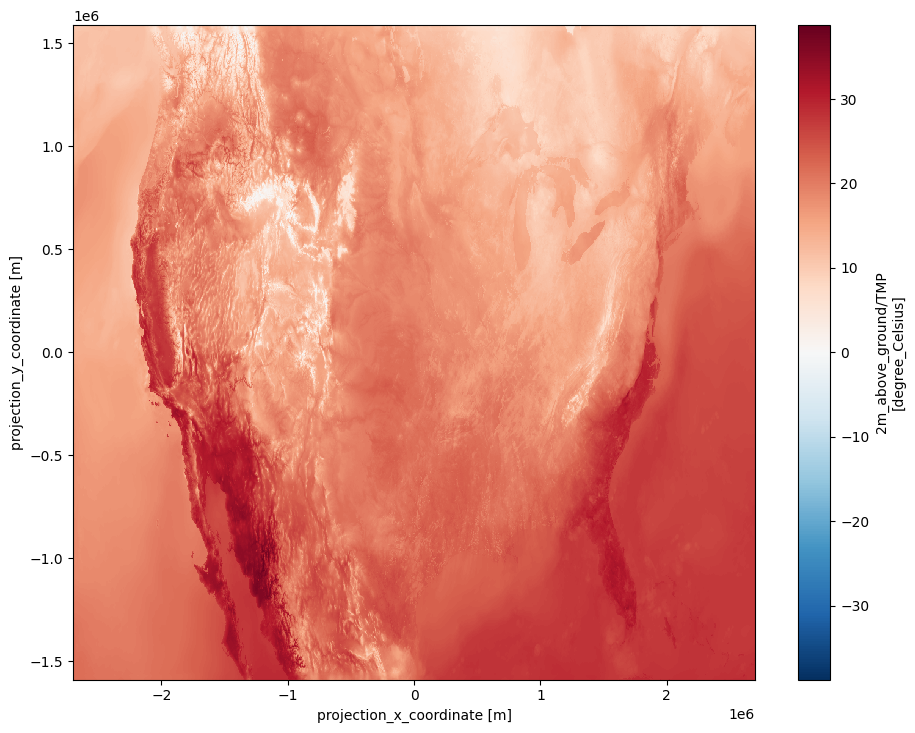

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


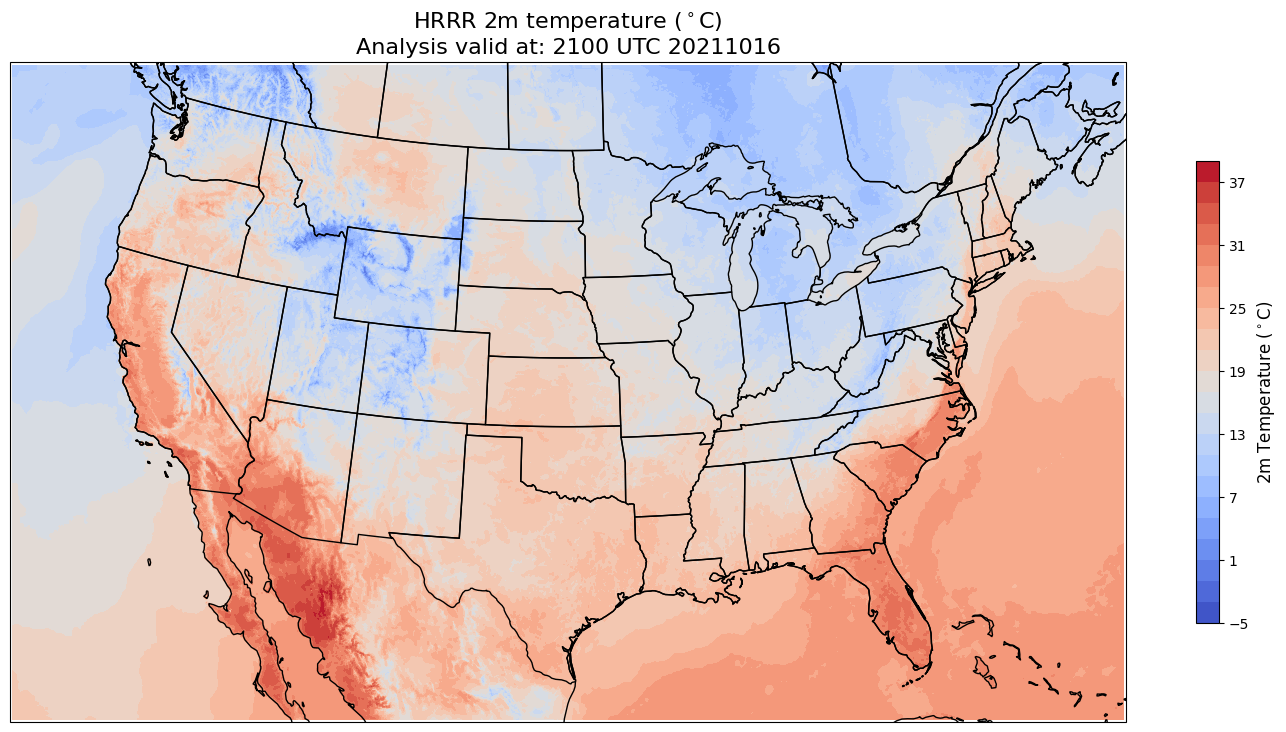

In [4]:
# Define coordinates for projection
lon1 = -97.5
lat1 = 38.5
slat = 38.5

# Define the Lambert Conformal projection
projData = ccrs.LambertConformal(
    central_longitude=lon1,
    central_latitude=lat1,
    standard_parallels=[slat, slat],
    globe=ccrs.Globe(
        semimajor_axis=6371229,
        semiminor_axis=6371229
    )
)

# Display dataset coordinates
ds.coords

# Extract temperature data
airTemp = ds.TMP

# Display the temperature data
airTemp

# Convert temperature units to Celsius
airTemp = airTemp.metpy.convert_units('degC')

# Display the converted temperature data
airTemp

# Extract projection coordinates
x = airTemp.projection_x_coordinate
y = airTemp.projection_y_coordinate

# Plot temperature data
airTemp.plot(figsize=(11, 8.5))

# Compute minimum and maximum temperatures
minTemp = airTemp.min().compute()
maxTemp = airTemp.max().compute()

# Display minimum and maximum temperature values
minTemp.values, maxTemp.values

# Define contour levels
fint = np.arange(np.floor(minTemp.values), np.ceil(maxTemp.values) + 2, 2)

# Define plot bounds and resolution
latN = 50.4
latS = 24.25
lonW = -123.8
lonE = -71.2
res = '50m'

# Create a figure and axis with projection
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=projData)
ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))

# Add the title
tl1 = 'HRRR 2m temperature ($^\\circ$C)'
tl2 = f'Analysis valid at: {hour}00 UTC {date}'
plt.title(f'{tl1}\n{tl2}', fontsize=16)

# Contour fill
CF = ax.contourf(x, y, airTemp, levels=fint, cmap=plt.get_cmap('coolwarm'))

# Make a colorbar for the ContourSet returned by the contourf call
cbar = fig.colorbar(CF, shrink=0.5)
cbar.set_label(r'2m Temperature ($^\circ$C)', size='large')

# Show the plot
plt.show()

---

## Other Ways to Access

There are other common ways to access data and use data with FSSpec and PelicanFS. This section will will cover the following topics

1. Using an Intake Catalog
2. Directly Accessing Data

### Intake Catalog

In order to use PelicanFS with an Intake catalog, the paths in the catalog itself need to use the `osdf` or `pelican` schemes.

Here's an example using the catalog located at https://data.gdex.ucar.edu/d850001/catalogs/osdf/cmip6-aws/cmip6-osdf-zarr.json

An entry in the catalog's csv file looks like:

```
HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ta,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/ta/gn/v20170706/,,20170706
```

Notice how the path is using the 'osdf' scheme and the '/aws-opendata/us-west-2' namespace. If all the paths in the csv file are formatted like this, then you can use the Intake catalog exactly as usual.

Here is a workflow and plot which uses an Intake catalog and the `osdf` scheme. If you want to understand more about the underlying workflow, please look at the [Global Mean Surface Temperature Anomalies (GMSTA) from CMIP6 data](http://projectpythia.org/osdf-cookbook/notebooks/cmip6-gmst/) notebook.

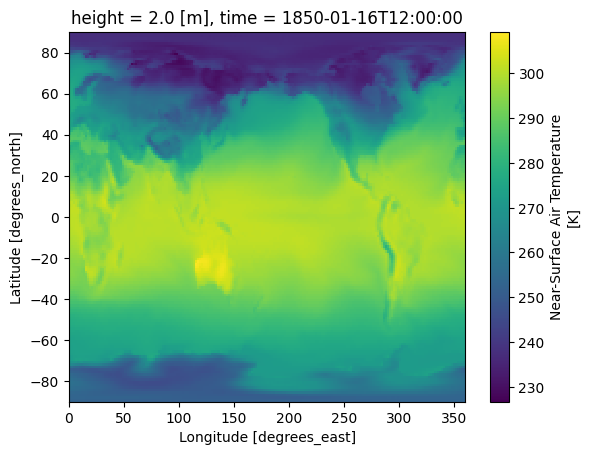

In [5]:
gdex_url    =  'https://data.gdex.ucar.edu/'
cat_url     = gdex_url +  'd850001/catalogs/osdf/cmip6-aws/cmip6-osdf-zarr.json'

col = intake.open_esm_datastore(cat_url)

expts = ['historical']

query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['tas'],
    member_id = 'r1i1p1f1',
    #activity_id = 'CMIP',
)

col_subset = col.search(require_all_on=["source_id"], **query)

ds = xr.open_zarr(col_subset.df['zstore'][0])

ds.tas.isel(time=0).plot()

### Direct Access of Data

You can also access the data directly using normal file system calls.

For example, let's say you want to read in a csv object from the OSDF. Just use the same pattern we've shown before of 

```osdf:///<namespace-path>``` 

for your path.

In [6]:
with fsspec.open('osdf:///ndp/burnpro3d/YosemiteBurnExample/burnpro3d-yosemite-example.csv') as ex_csv:
    content = ex_csv.read()
    print(content.decode())

Reminder: This tool is in beta testing through and this report has been provided to users for the purpose of getting feedback.,,,,,,,,,,,,,,,,
id,name,fdfm,live_fm,wind_speed_mph,wind_direction,surface,midstory,canopy,outside_surface_growth_rate,outside_canopy_consumption_rate,time_to_traverse_buffer,run_max_mem_rss_MB,elapsed_model_s,fuels_dens_surface_final_plot,run_zarr,fuel_zarr
bcbb40c0-2875-4753-b77a-a7d382b8045f,Yosemite valentine's day burn,0.08,0.9,3,30,0.9069966673851013,0.7914127111434937,0.229936882853508,-1,-1,-1,7116,53844,https://wifire-data.sdsc.edu/data/burnpro3d/d/bc/bb/run_bcbb40c0-2875-4753-b77a-a7d382b8045f/png/run_bcbb40c0-2875-4753-b77a-a7d382b8045f_fuels-dens_7080_000.png,https://wifire-data.sdsc.edu/data/burnpro3d/d/bc/bb/run_bcbb40c0-2875-4753-b77a-a7d382b8045f/quicfire.zarr,http://wifire-data.sdsc.edu/data/burnpro3d/d/49/7f/fuel_497fc5d4-9a4a-48c5-90f1-6fc50778f0b9/fastfuels.zarr
d27d6ab2-b9ad-42d5-95b8-d191d88dc98a,Yosemite valentine's day burn,0.08,0.9,5,45

## Summary
In this notebook we demonstrated how to use PelicanFS and gave an overview of a few different common usages. The main example showed how to use PelicanFS and Xarray to open a Zarr store. We also showed how to use PelicanFS and an intake catalog.

### What's next?
The following notebooks all demonstrate various workflows which will use PelicanFS to access data from the OSDF.